In [35]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

from dataPath import DATA_PATH
%matplotlib inline

import matplotlib

matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['figure.figsize'] = (10, 10)

MAX_FEATURES = 1000
MIN_MATCH_COUNT = 10

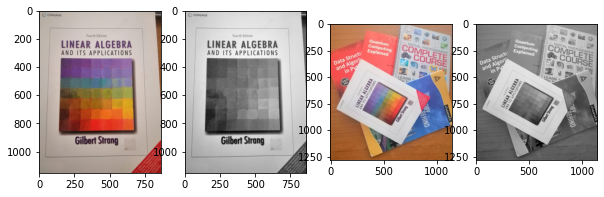

In [36]:
img1 = cv.imread(DATA_PATH + "images/book.jpeg")
img1Gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img2 = cv.imread(DATA_PATH + "images/book_scene.jpeg")
img2Gray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

plt.subplot(141);
plt.imshow(img1[..., ::-1])
plt.subplot(142);
plt.imshow(img1Gray, cmap='gray')
plt.subplot(143);
plt.imshow(img2[..., ::-1])
plt.subplot(144);
plt.imshow(img2Gray, cmap='gray')

In [37]:
#Find features in both images
orb = cv.ORB_create(MAX_FEATURES)
kp1, desc1 = orb.detectAndCompute(img1Gray, None)
kp2, desc2 = orb.detectAndCompute(img2Gray, None)

#Setup matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)

#Find matches or corresponding points
matches = flann.knnMatch(np.float32(desc1), np.float32(desc2), k=2)

#Find good matches
good = []
for m, n in matches:
    if m.distance < 0.9 * n.distance:
        good.append(m)

In [56]:
#Find the location of the book in the cluttered image

if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()
    h, w, d = img1.shape
    pts = np.float32([
        [0, 0],
        [0, h - 1],
        [w - 1, h - 1],
        [w - 1, 0]]
    ).reshape(-1, 1, 2)
    dst = cv.perspectiveTransform(pts, M)
    img2 = cv.polylines(img2, [np.int32(dst)], True, (0, 0, 255), 10, cv.LINE_AA)
else:
    print("Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT));
    matchesMask = None

[[[   0.    0.]]

 [[   0. 1151.]]

 [[ 863. 1151.]]

 [[ 863.    0.]]]


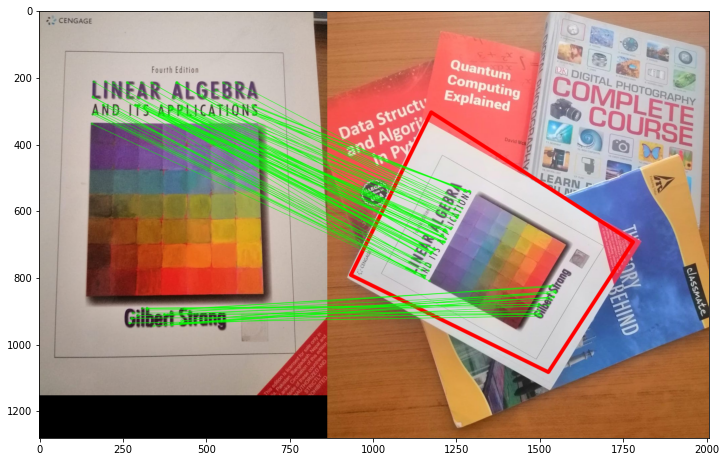

In [39]:
#Display the matches and the detected object
draw_params = dict(
    matchColor = (0,255,0),
    singlePointColor = None,
    matchesMask = matchesMask,
    flags = 2
)
img3 = cv.drawMatches(img1, kp1, img2,kp2,good,None,**draw_params)
plt.figure(figsize=(12,12))
plt.imshow(img3[...,::-1]);plt.show()